### Setup

apt install requirements

In [1]:
# !apt-get install -y \
#     libgl1-mesa-dev \
#     libgl1-mesa-glx \
#     libglew-dev \
#     libosmesa6-dev \
#     software-properties-common

# !apt-get install -y patchelf

Clone repo and install dependencies

In [2]:
# %cd /content

# ## TODO: use when repo is public
# # !git clone https://github.com/jannerm/diffuser.git
# ## backup for private repo
# !curl -L -o diffuser.zip https://www.dropbox.com/s/fe1scd8m2jf7zvj/diffuser.tar?dl=1
# !tar -xf diffuser.zip
# ## /TODO

# %cd diffuser
# %pip install -f https://download.pytorch.org/whl/torch_stable.html \
#                 typed-argument-parser \
#                 scikit-image==0.17.2 \
#                 scikit-video==1.1.11 \
#                 gitpython \
#                 einops \
#                 pillow \
#                 free-mujoco-py \
#                 gym \
#                 git+https://github.com/JannerM/d4rl.git@0e84a4d29db3ae501043215ce1d91843929f1949 \
#                 git+https://github.com/aravindr93/mjrl

# %pip install -e .

In [3]:
import os
import json
import numpy as np
from os.path import join
import pdb

from diffuser.guides.policies import Policy
import diffuser.datasets as datasets
import diffuser.utils as utils

/opt/conda/envs/diffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Nov 28 2023 23:51:11


In [4]:
os.chdir('/root/diffuser')

Arguments

In [5]:
savepath = 'logs/maze2d-large-v1/rollouts'
os.makedirs(savepath, exist_ok=True)
vis_freq = 10
batch_size = 1

Loading

In [36]:
dataset = 'maze2d-large-v1'

env = datasets.load_environment(dataset)

diffusion_experiment = utils.load_diffusion('logs/pretrained', dataset, 'diffusion/H384_T256', epoch='latest')

diffusion = diffusion_experiment.ema
dataset = diffusion_experiment.dataset
renderer = diffusion_experiment.renderer

policy = Policy(diffusion, dataset.normalizer)

[ utils/serialization ] Loaded config from logs/pretrained/maze2d-large-v1/diffusion/H384_T256/dataset_config.pkl

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-large-v1
    horizon: 384
    max_path_length: 40000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/serialization ] Loaded config from logs/pretrained/maze2d-large-v1/diffusion/H384_T256/render_config.pkl

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-large-v1

[ utils/serialization ] Loaded config from logs/pretrained/maze2d-large-v1/diffusion/H384_T256/model_config.pkl

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 384
    transition_dim: 6

[ utils/serialization ] Loaded config from logs/pretrained/maze2d-large-v1/diffusion/H384_T256/diffusion_config.pkl

[utils/config ] Config: <class 'diffuser.mod

load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]


[ utils/preprocessing ] Segmented maze2d-large-v1 | 1061 paths | min length: 67 | max length: 30470
[ datasets/buffer ] Finalized replay buffer | 1062 episodes
[ datasets/buffer ] Fields:
    actions: (1062, 40000, 2)
    infos/goal: (1062, 40000, 2)
    infos/qpos: (1062, 40000, 2)
    infos/qvel: (1062, 40000, 2)
    observations: (1062, 40000, 4)
    rewards: (1062, 40000, 1)
    terminals: (1062, 40000, 1)
    timeouts: (1062, 40000, 1)
    next_observations: (1062, 40000, 4)
    normed_observations: (1062, 40000, 4)
    normed_actions: (1062, 40000, 2)
[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]

[ utils/serialization ] Loading model epoch: 1960000



Main Loop

In [40]:
from tqdm import tqdm

Resetting target


  0%|          | 0/10 [00:00<?, ?it/s]


                                                                                                    
1 / 256 [                                                            ]   0% | 107.3 Hz
t : 255
                                                                                                    
                                                                                                    
2 / 256 [                                                            ]   0% | 115.6 Hz
t : 254
                                                                                                    
                                                                                                    
3 / 256 [                                                            ]   1% | 119.3 Hz
t : 253
                                                                                                    
                                                                                                    
4 / 256

 10%|█         | 1/10 [00:09<01:27,  9.73s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 781 | r: 1.00 |  R: 424.00 | score: 1.5612 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.23859776e-05 -4.33638378e-05]
maze | pos: [1.02646033 6.05808182] | goal: [1.02885156 6.05934053]
t: 782 | r: 1.00 |  R: 425.00 | score: 1.5650 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.15427443e-05 -4.29200022e-05]
maze | pos: [1.0264848 6.0580947] | goal: [1.02885156 6.05934053]
t: 783 | r: 1.00 |  R: 426.00 | score: 1.5687 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.07081416e-05 -4.24807093e-05]
maze | pos: [1.02650903 6.05810745] | goal: [1.02885156 6.05934053]
t: 784 | r: 1.00 |  R: 427.00 | score: 1.5724 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.98820813e-05 -4.20459126e-05]
maze | pos: [1.026533   6.05812007] | goal: [1.02885156 6.05934053]
t: 785 | r: 1.00 |  R: 428.00 | score: 1.5762 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.90644757e-05 -4.16155662e-05]
maze | pos: [1.02655673 6.05813256] | goal: [1.0

 20%|██        | 2/10 [00:21<01:28, 11.12s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 781 | r: 1.00 |  R: 895.00 | score: 3.3234 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.62427583e-05 -1.86916011e-04]
maze | pos: [1.02808992 6.05391513] | goal: [1.02885156 6.05934053]
t: 782 | r: 1.00 |  R: 896.00 | score: 3.3271 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.59741596e-05 -1.85002897e-04]
maze | pos: [1.02809771 6.05397066] | goal: [1.02885156 6.05934053]
t: 783 | r: 1.00 |  R: 897.00 | score: 3.3308 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.57083100e-05 -1.83109363e-04]
maze | pos: [1.02810543 6.05402562] | goal: [1.02885156 6.05934053]
t: 784 | r: 1.00 |  R: 898.00 | score: 3.3346 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.54451814e-05 -1.81235210e-04]
maze | pos: [1.02811307 6.05408002] | goal: [1.02885156 6.05934053]
t: 785 | r: 1.00 |  R: 899.00 | score: 3.3383 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.51847461e-05 -1.79380240e-04]
maze | pos: [1.02812063 6.05413386] | goal: [1

 30%|███       | 3/10 [00:35<01:27, 12.46s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 1159.00 | score: 4.3110 | ref_max_score: 273.99 | ref_min_score: 6.7[0.00023339 0.00181845]
maze | pos: [1.03562603 6.11212208] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 1160.00 | score: 4.3148 | ref_max_score: 273.99 | ref_min_score: 6.7[0.00023101 0.00179984]
maze | pos: [1.0355567  6.11158185] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 1161.00 | score: 4.3185 | ref_max_score: 273.99 | ref_min_score: 6.7[0.00022864 0.00178142]
maze | pos: [1.03548807 6.11104715] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 1162.00 | score: 4.3223 | ref_max_score: 273.99 | ref_min_score: 6.7[0.0002263  0.00176318]
maze | pos: [1.03542014 6.11051793] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 1163.00 | score: 4.3260 | ref_max_score: 273.99 | ref_min_score: 6.7[0.00022398 0.00174514]
maze | pos: [1.03535291 6.10999412] | goal: [1.02885156 6.05934053]
t: 796 | r: 1.00 |  R: 

 40%|████      | 4/10 [00:51<01:23, 13.90s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 1629.00 | score: 6.0694 | ref_max_score: 273.99 | ref_min_score: 6.7[-1.34913731e-04  3.77042034e-05]
maze | pos: [1.02493568 6.06043486] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 1630.00 | score: 6.0732 | ref_max_score: 273.99 | ref_min_score: 6.7[-1.33532868e-04  3.73182951e-05]
maze | pos: [1.02497576 6.06042366] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 1631.00 | score: 6.0769 | ref_max_score: 273.99 | ref_min_score: 6.7[-1.32166138e-04  3.69363365e-05]
maze | pos: [1.02501543 6.06041258] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 1632.00 | score: 6.0807 | ref_max_score: 273.99 | ref_min_score: 6.7[-1.30813397e-04  3.65582874e-05]
maze | pos: [1.02505469 6.0604016 ] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 1633.00 | score: 6.0844 | ref_max_score: 273.99 | ref_min_score: 6.7[-1.29474502e-04  3.61841076e-05]
maze | pos: [1.02509355 6.06039074] | goa

 50%|█████     | 5/10 [01:10<01:17, 15.42s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 2112.00 | score: 7.8765 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.45985062e-04 -1.29458812e-05]
maze | pos: [1.02171176 6.05896471] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 2113.00 | score: 7.8802 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.43467367e-04 -1.28133781e-05]
maze | pos: [1.02178484 6.05896856] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 2114.00 | score: 7.8839 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.40975440e-04 -1.26822312e-05]
maze | pos: [1.02185717 6.05897237] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 2115.00 | score: 7.8877 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.38509019e-04 -1.25524266e-05]
maze | pos: [1.02192876 6.05897614] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 2116.00 | score: 7.8914 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.36067842e-04 -1.24239506e-05]
maze | pos: [1.02199962 6.05897986] | goa

 60%|██████    | 6/10 [01:30<01:07, 16.95s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 2566.00 | score: 9.5750 | ref_max_score: 273.99 | ref_min_score: 6.7[ 1.54869261e-04 -8.47809399e-05]
maze | pos: [1.0333468  6.05687966] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 2567.00 | score: 9.5787 | ref_max_score: 273.99 | ref_min_score: 6.7[ 1.53284150e-04 -8.39131938e-05]
maze | pos: [1.03330079 6.05690485] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 2568.00 | score: 9.5825 | ref_max_score: 273.99 | ref_min_score: 6.7[ 1.51715263e-04 -8.30543293e-05]
maze | pos: [1.03325526 6.05692978] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 2569.00 | score: 9.5862 | ref_max_score: 273.99 | ref_min_score: 6.7[ 1.50162434e-04 -8.22042553e-05]
maze | pos: [1.03321018 6.05695445] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 2570.00 | score: 9.5900 | ref_max_score: 273.99 | ref_min_score: 6.7[ 1.48625498e-04 -8.13628820e-05]
maze | pos: [1.03316557 6.05697887] | goa

 70%|███████   | 7/10 [01:51<00:55, 18.56s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 3030.00 | score: 11.3109 | ref_max_score: 273.99 | ref_min_score: 6.7[-4.12522325e-05 -7.04220551e-05]
maze | pos: [1.02765426 6.05729643] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 3031.00 | score: 11.3147 | ref_max_score: 273.99 | ref_min_score: 6.7[-4.08300095e-05 -6.97012744e-05]
maze | pos: [1.02766651 6.05731736] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 3032.00 | score: 11.3184 | ref_max_score: 273.99 | ref_min_score: 6.7[-4.0412108e-05 -6.8987871e-05]
maze | pos: [1.02767864 6.05733806] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 3033.00 | score: 11.3222 | ref_max_score: 273.99 | ref_min_score: 6.7[-3.99984838e-05 -6.82817695e-05]
maze | pos: [1.02769065 6.05735856] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 3034.00 | score: 11.3259 | ref_max_score: 273.99 | ref_min_score: 6.7[-3.95890931e-05 -6.75828949e-05]
maze | pos: [1.02770253 6.05737884] | 

 80%|████████  | 8/10 [02:15<00:40, 20.20s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 3493.00 | score: 13.0431 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.63204327e-05 -1.97848670e-05]
maze | pos: [1.02808766 6.05876621] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 3494.00 | score: 13.0469 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.60510390e-05 -1.95823658e-05]
maze | pos: [1.02809548 6.05877209] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 3495.00 | score: 13.0506 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.57844026e-05 -1.93819373e-05]
maze | pos: [1.02810322 6.0587779 ] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 3496.00 | score: 13.0544 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.55204952e-05 -1.91835601e-05]
maze | pos: [1.02811088 6.05878366] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 3497.00 | score: 13.0581 | ref_max_score: 273.99 | ref_min_score: 6.7[-2.52592890e-05 -1.89872134e-05]
maze | pos: [1.02811846 6.05878936] 

 90%|█████████ | 9/10 [02:41<00:21, 21.85s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 3961.00 | score: 14.7940 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.43665229e-05 -3.95348547e-05]
maze | pos: [1.02640284 6.05819295] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 3962.00 | score: 14.7978 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.35030184e-05 -3.91302093e-05]
maze | pos: [1.0264279 6.0582047] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 3963.00 | score: 14.8015 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.26483520e-05 -3.87297055e-05]
maze | pos: [1.02645271 6.05821632] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 3964.00 | score: 14.8053 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.18024333e-05 -3.83333009e-05]
maze | pos: [1.02647726 6.05822783] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 3965.00 | score: 14.8090 | ref_max_score: 273.99 | ref_min_score: 6.7[-8.09651727e-05 -3.79409537e-05]
maze | pos: [1.02650157 6.05823922] | 

100%|██████████| 10/10 [03:08<00:00, 18.83s/it]

Saved 1 samples to: logs/maze2d-large-v1/rollouts/rollout.png
t: 791 | r: 1.00 |  R: 4432.00 | score: 16.5562 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.88426226e-05  3.50166889e-06]
maze | pos: [1.02656317 6.05944212] | goal: [1.02885156 6.05934053]
t: 792 | r: 1.00 |  R: 4433.00 | score: 16.5599 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.80356561e-05  3.46582877e-06]
maze | pos: [1.0265866  6.05944107] | goal: [1.02885156 6.05934053]
t: 793 | r: 1.00 |  R: 4434.00 | score: 16.5637 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.72369490e-05  3.43035547e-06]
maze | pos: [1.02660978 6.05944005] | goal: [1.02885156 6.05934053]
t: 794 | r: 1.00 |  R: 4435.00 | score: 16.5674 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.64464168e-05  3.39524525e-06]
maze | pos: [1.02663273 6.05943903] | goal: [1.02885156 6.05934053]
t: 795 | r: 1.00 |  R: 4436.00 | score: 16.5711 | ref_max_score: 273.99 | ref_min_score: 6.7[-7.56639759e-05  3.36049439e-06]
maze | pos: [1.02665544 6.05943802] 

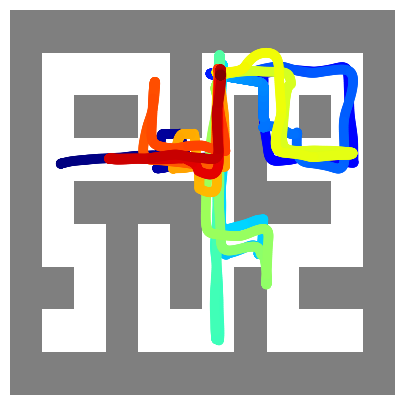

In [41]:
observation = env.reset()
isconditioned = True

if isconditioned:
    print('Resetting target')
    env.set_target()

## set conditioning xy position to be the goal
target = env._target
cond = {
    diffusion.horizon - 1: np.array([*target, 0, 0]),
}

## observations for rendering
rollout = [observation.copy()]

total_reward = 0
scorelist = []
for i in tqdm(range(10)):
    total_reward = 0
    for t in range(env.max_episode_steps):

        state = env.state_vector().copy()

        ## can replan if desired, but the open-loop plans are good enough for maze2d
        ## that we really only need to plan once
        if t == 0:
            cond[0] = observation

            action, samples = policy(cond, batch_size=batch_size)
            actions = samples.actions[0]
            sequence = samples.observations[0]
        # pdb.set_trace()

        # ####
        if t < len(sequence) - 1:
            next_waypoint = sequence[t+1]
        else:
            next_waypoint = sequence[-1].copy()
            next_waypoint[2:] = 0
            # pdb.set_trace()

        ## can use actions or define a simple controller based on state predictions
        action = next_waypoint[:2] - state[:2] + (next_waypoint[2:] - state[2:])
        # pdb.set_trace()
        ####

        # else:
        #     actions = actions[1:]
        #     if len(actions) > 1:
        #         action = actions[0]
        #     else:
        #         # action = np.zeros(2)
        #         action = -state[2:]
        #         pdb.set_trace()



        next_observation, reward, terminal, _ = env.step(action)
        total_reward += reward
        score = env.get_normalized_score(total_reward)
        print(
            f't: {t} | r: {reward:.2f} |  R: {total_reward:.2f} | score: {score:.4f} | ref_max_score: {env.ref_max_score} | ref_min_score: {env.ref_min_score}'
            f'{action}'
        )

        xy = next_observation[:2]
        goal = env.unwrapped._target
        print(f'maze | pos: {xy} | goal: {goal}')

        ## update rollout observations
        rollout.append(next_observation.copy())

        # logger.log(score=score, step=t)

        if t % vis_freq == 0 or terminal:
            fullpath = join(savepath, f'{t}.png')

            if t == 0: renderer.composite(fullpath, samples.observations, ncol=1)



            ## save rollout thus far
            renderer.composite(join(savepath, 'rollout.png'), np.array(rollout)[None], ncol=1)



        if terminal:
            break

        observation = next_observation
    scorelist.append((total_reward, score)) 

In [42]:
scorelist

[(442.0, 1.6285682217815856),
 (913.0, 3.390699240525272),
 (1167.0, 4.340977964009128),
 (1637.0, 6.099367727935949),
 (2120.0, 7.906393804482024),
 (2574.0, 9.604923491338996),
 (3038.0, 11.340865726364623),
 (3501.0, 13.073066706573384),
 (3969.0, 14.823973960866475),
 (4440.0, 16.58610497961016)]

In [43]:
scorelist2 = [(scorelist[i][0]) if i==0 else (scorelist[i][0]-scorelist[i-1][0]) for i in range(len(scorelist))]

In [44]:
scorelist2 = [(x, 100*(x-env.ref_min_score)/(env.ref_max_score-env.ref_min_score)) for x in scorelist2]

In [45]:
scorelist2

[(442.0, 162.85682217815855),
 (471.0, 173.70646114706872),
 (254.0, 92.5212316210857),
 (470.0, 173.33233566538215),
 (483.0, 178.1959669273074),
 (454.0, 167.34632795839724),
 (464.0, 171.0875827752628),
 (463.0, 170.71345729357625),
 (468.0, 172.58408470200905),
 (471.0, 173.70646114706872)]

In [46]:
np.mean([s[0] for s in scorelist2]), np.std([s[0] for s in scorelist2]), np.mean([s[1] for s in scorelist2]), np.std([s[1] for s in scorelist2])

(444.0, 64.18411018312867, 163.60507314153165, 24.0129111388861)

In [12]:
np.std([s[1] for s in scorelist])

21.95702474131786

In [ ]:
json_path = join(savepath, 'rollout.json')
json_data = {'score': score, 'step': t, 'return': total_reward, 'term': terminal,
    'epoch_diffusion': diffusion_experiment.epoch}
json.dump(json_data, open(json_path, 'w'), indent=2, sort_keys=True)

In [ ]:
json_data

{'score': 1.6210857121478544,
 'step': 799,
 'return': 440.0,
 'term': False,
 'epoch_diffusion': 1960000}

In [ ]:
json_data

{'score': 1.3367503460660706,
 'step': 799,
 'return': 364.0,
 'term': False,
 'epoch_diffusion': 1960000}

In [ ]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99


In [ ]:
json_data

{'score': 1.6173444573309887,
 'step': 799,
 'return': 439.0,
 'term': False,
 'epoch_diffusion': 1960000}

In [28]:
100*(439.0-env.ref_min_score)/(env.ref_max_score - env.ref_min_score)

161.73444573309888

In [ ]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99


In [ ]:
print('Ref min score:', env.ref_min_score, 'Ref max score:', env.ref_max_score)

Ref min score: 6.7 Ref max score: 273.99


In [ ]:
(return-minscore)/(max-min)